**Step 1: Install Required Libraries**

In [10]:
# Installments (if not already installed)
!pip install nltk keybert transformers torch seaborn matplotlib beautifulsoup4 requests --quiet

**Step 2: Import Libraries**

In [11]:
# Step 2: Imports
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from keybert import KeyBERT
import nltk
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Step 3: Download NLTK Word List**

In [12]:
nltk.download('words')
from nltk.corpus import words

# Prepare English vocabulary for keyword filtering
english_vocab = set(w.lower() for w in words.words())


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


**Step 4: Global Visited Set**

In [13]:
# Global visited URL set
visited = set()

**Step 5: Internal Link Extractor**

In [14]:
#Internal Link Extractor
def get_internal_links(url, base_domain):
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()

        for tag in soup.find_all('a', href=True):
            href = tag['href']
            full_url = urljoin(url, href)
            parsed = urlparse(full_url)

            if parsed.netloc == base_domain and full_url.startswith("http") and "javascript" not in full_url:
                if full_url not in visited:
                    links.add(full_url)

        return links
    except:
        return set()

**Step 6: Clean Text Extractor**

In [15]:
#Step 4: Clean Text Extractor
def extract_clean_text(url):
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = ' '.join(p.get_text() for p in paragraphs)
        return ' '.join(text.split())
    except:
        return ""

**Step 7: Website Crawler**

In [16]:
#Crawler with Limits
def crawl_site(start_url, max_pages=30, max_depth=2):
    base_domain = urlparse(start_url).netloc
    to_visit = [(start_url, 0)]
    full_text = ""

    while to_visit and len(visited) < max_pages:
        url, depth = to_visit.pop(0)
        if url in visited or depth > max_depth:
            continue

        visited.add(url)
        print(f"Crawling: {url}")
        full_text += " " + extract_clean_text(url)

        if depth < max_depth:
            internal_links = get_internal_links(url, base_domain)
            for link in internal_links:
                to_visit.append((link, depth + 1))

    return full_text

**Step 8: Keyword Extraction Using KeyBERT + NLTK**

In [17]:
#Extract Keywords using KeyBERT + NLTK Filter
def extract_keywords(text, top_n=20):
    kw_model = KeyBERT()
    raw_keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 1),
        stop_words='english',
        top_n=100
    )

    filtered = []
    seen = set()

    for word, score in raw_keywords:
        word = word.lower().strip()
        if word.isalpha() and len(word) > 3 and word in english_vocab and word not in seen:
            filtered.append((word, score))
            seen.add(word)
        if len(filtered) >= top_n:
            break

    return filtered

**Step 9: Load BERT Model (SimCSE)**

In [18]:
#BERT Model Setup
model_name = "princeton-nlp/sup-simcse-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs, return_dict=True)
        return outputs.pooler_output[0]


**Step 10: Semantic Similarity Calculator**

In [19]:
 #Similarity Function
def compare_keywords(dataset1, dataset2):
    embeddings1 = [get_embedding(word) for word in dataset1]
    embeddings2 = [get_embedding(word) for word in dataset2]
    similarity_matrix = np.zeros((len(dataset1), len(dataset2)))

    for i in range(len(dataset1)):
        for j in range(len(dataset2)):
            similarity_matrix[i][j] = torch.nn.functional.cosine_similarity(
                embeddings1[i], embeddings2[j], dim=0).item()

    # Matched pairs
    threshold = 0.5
    matches = []
    for i, w1 in enumerate(dataset1):
        for j, w2 in enumerate(dataset2):
            score = similarity_matrix[i][j]
            if score >= threshold:
                matches.append((w1, w2, round(score, 2)))
    df = pd.DataFrame(matches, columns=["Dataset1_Word", "Dataset2_Word", "Similarity"])
    print("\n All Matched Word Pairs (Above Threshold):\n")
    print(df.sort_values(by="Similarity", ascending=False))

    # Best match for each
    print("\n Closest Match for Each Word in Dataset 1:")
    for i, w1 in enumerate(dataset1):
        best_idx = np.argmax(similarity_matrix[i])
        best_word = dataset2[best_idx]
        score = similarity_matrix[i][best_idx]
        print(f"{w1} → {best_word} ({round(score, 2)})")

    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(similarity_matrix, xticklabels=dataset2, yticklabels=dataset1,
                cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title("Word-to-Word Semantic Similarity (SimCSE)")
    plt.xlabel("Dataset 2")
    plt.ylabel("Dataset 1")
    plt.tight_layout()
    plt.show()

    # Overall Similarity
    embedding1 = get_embedding(", ".join(dataset1))
    embedding2 = get_embedding(", ".join(dataset2))
    overall_similarity = float(torch.nn.functional.cosine_similarity(embedding1, embedding2, dim=0))
    print(f"\n Overall Dataset Similarity Score: {round(overall_similarity, 2)}")
    if overall_similarity >= 0.7:
        print("FINAL DECISION: Datasets are SEMANTICALLY SIMILAR")
    elif overall_similarity >= 0.5:
        print("FINAL DECISION: Datasets are MODERATELY similar")
    else:
        print("FINAL DECISION: Datasets are NOT similar")

**Step 11: Main Driver Function**

In [20]:
def main():
    start_url = "https://www.cryoshelter.com/" #sample
    print(f"Starting crawl from: {start_url}\n")

    full_text = crawl_site(start_url, max_pages=30, max_depth=2)

    print("\nFinished crawling. Extracting keywords...\n")
    keywords = extract_keywords(full_text, top_n=20)

    print("Top Keywords:")
    for i, (kw, score) in enumerate(keywords, 1):
        print(f"{i}. {kw} — Score: {score:.5f}")

    keyword_array = [kw for kw, _ in keywords]
    print("\n Keywords Array:")
    print(keyword_array)

    # Define a comparison dataset (you can replace this)
    static_keywords = ["oxygen", "cooling", "cryogenics", "nitrogen", "vaporization",
                       "storage", "liquefication", "refrigeration"]

    print("\n Semantic Comparison with Static Domain Keywords:")
    compare_keywords(static_keywords, keyword_array)

**Step 12: Run the Project**

Starting crawl from: https://www.cryoshelter.com/

Crawling: https://www.cryoshelter.com/
Crawling: https://www.cryoshelter.com/product/
Crawling: http://www.cryoshelter.com/product/
Crawling: https://www.cryoshelter.com/contact/
Crawling: https://www.cryoshelter.com/technology/
Crawling: https://www.cryoshelter.com/career/
Crawling: https://www.cryoshelter.com/hexagon-composites/
Crawling: https://www.cryoshelter.com/lng-fuelling-station/
Crawling: https://www.cryoshelter.com/webcast-14th-september-2022-navigating-the-road-to-zero-emissions/
Crawling: https://www.cryoshelter.com/who-we-are/
Crawling: https://www.cryoshelter.com/#top
Crawling: https://www.cryoshelter.com/#content
Crawling: https://www.cryoshelter.com/suscribe/
Crawling: https://www.cryoshelter.com/impressum/
Crawling: https://www.cryoshelter.com/privacy-statement/
Crawling: https://www.cryoshelter.com/downloads/
Crawling: https://www.cryoshelter.com/lng-methane-is-the-future/
Crawling: https://www.cryoshelter.com/produ

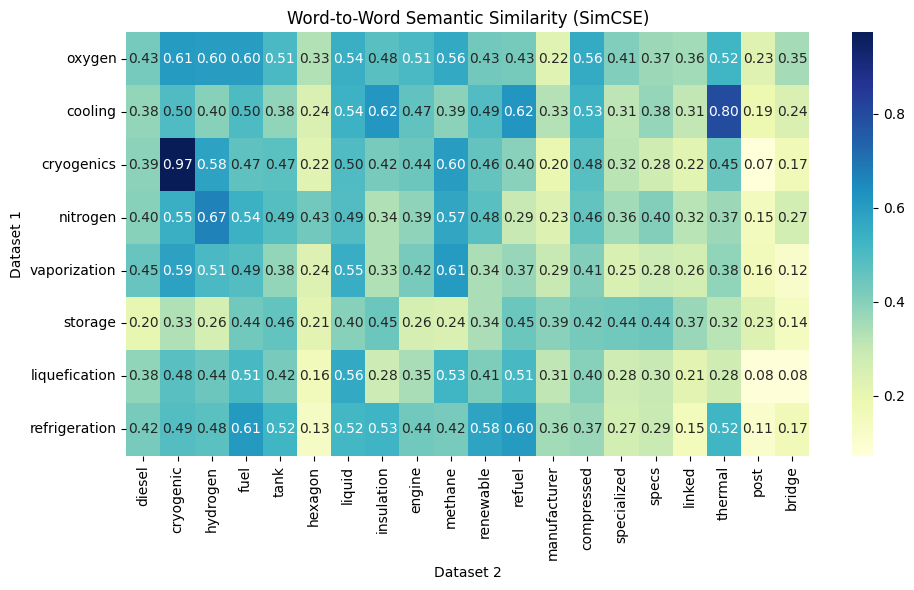


 Overall Dataset Similarity Score: 0.81
FINAL DECISION: Datasets are SEMANTICALLY SIMILAR


In [21]:
main()